In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi
import os
import sqlite3
import pickle
from PyQt5 import QtWidgets, QtGui
from PyQt5.QtCore import Qt
from PyQt5.QtWidgets import QLabel, QVBoxLayout, QPushButton, QFileDialog, QWidget, QApplication


# *Read Gambar*

Membaca gambar yang dimasukan lalu mengonversi representasi warna citra dari format BGR (yang digunakan oleh OpenCV) ke format RGB (yang digunakan oleh matplotlib) menggunakan fungsi cv2.cvtColor

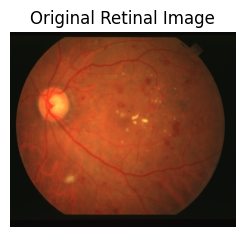

In [40]:
image_path = "Testdata/im0009.ppm"
raw_image_bgr = cv2.imread(image_path)
raw_image_rgb = cv2.cvtColor(raw_image_bgr, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.title("Original Retinal Image")
plt.imshow(raw_image_rgb)
plt.axis('off')
plt.show()

# MASKING GAMBAR

 membuat sebuah masker lingkaran dengan ukuran yang sesuai dengan dimensi citra asli raw_image, lalu menerapkan masker tersebut pada citra asli menggunakan operasi bitwise AND. Hasilnya adalah sebuah citra baru masked_image yang hanya menampilkan area lingkaran dari citra asli, sementara area di luar lingkaran diubah menjadi hitam.

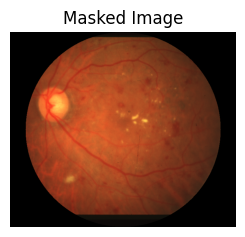

In [6]:
mask = np.zeros(raw_image_bgr.shape[:2], dtype="uint8")

(h, w) = raw_image_bgr.shape[:2]
center = (w // 2, h // 2)
radius = min(center[0], center[1], w - center[0], h - center[1])

for i in range(h):
    for j in range(w):
        if (i - center[1])**2 + (j - center[0])**2 <= radius**2:
            mask[i, j] = 255

masked_image = cv2.bitwise_and(raw_image_rgb, raw_image_rgb, mask=mask)

plt.subplot(1, 2, 1)
plt.title("Masked Image")
plt.imshow(masked_image)
plt.axis('off')
plt.show()


# Vessel Detecting using Frangi

### Gray Filter
mengekstrak saluran warna hijau (green channel) dari citra masked_image dan menyimpannya sebagai citra grayscale gray_image2. Notasi [:,:,1] adalah slicing dalam NumPy yang mengambil semua baris dan kolom dari dimensi ketiga (di sini adalah saluran warna) dengan indeks 1, yang merepresentasikan saluran hijau dalam format warna RGB.

In [7]:
gray_image_frangi = masked_image[:,:,1]

### CLAHE

1. membuat objek CLAHE (Contrast Limited Adaptive Histogram Equalization) dengan parameter clip limit 2.0 dan ukuran grid 8x8 untuk meningkatkan kontras citra
2. menerapkan CLAHE pada citra grayscale gray_image2 untuk menghasilkan citra equalized dengan kontras yang lebih baik
3. menghilangkan noise pada citra equalized menggunakan metode denoising Non-local Means dengan ukuran jendela template 15, menghasilkan citra denoised yang memiliki kontras yang ditingkatkan dan noise yang berkurang.

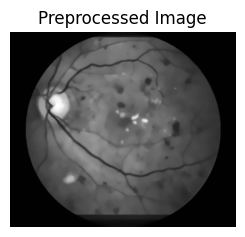

In [8]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized = clahe.apply(gray_image_frangi)
denoised = cv2.fastNlMeansDenoising(equalized, None, 15)

plt.subplot(1, 2, 1)
plt.title("Preprocessed Image")
plt.imshow(denoised, cmap='gray')
plt.axis('off')
plt.show()

### Frangi to normalize
 normalisasi pada citra dengan mengalikan setiap piksel dalam citra dengan rasio antara factor dan nilai piksel maksimum dalam citra. Hasilnya adalah citra yang memiliki nilai piksel maksimum sama dengan factor, sehingga rentang nilai piksel dalam citra tersebut dinormalisasi ke rentang baru yang ditentukan oleh factor. Fungsi ini mengembalikan citra yang telah dinormalisasi sebagai array NumPy.

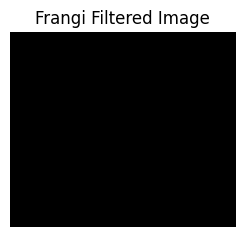

In [9]:
def normalize(image: np.ndarray, factor: float) -> np.ndarray:
    image = image * (factor / image.max())
    return image

vessels1 = frangi(denoised)
vessels = normalize(vessels1, 255).astype(np.uint8)

plt.subplot(1, 2, 1)
plt.title("Frangi Filtered Image")
plt.imshow(vessels1, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

### Finding Threshold
melakukan operasi thresholding pada citra vessels. Thresholding adalah proses mengonversi citra grayscale menjadi citra biner dengan mengubah setiap piksel menjadi hitam (0) atau putih (255) berdasarkan nilai ambang batas tertentu. Dalam kasus ini, nilai ambang batas adalah 0, artinya semua piksel dengan nilai lebih besar dari 0 akan diubah menjadi 255 (putih), sementara piksel dengan nilai 0 akan tetap 0 (hitam). Operasi ini menghasilkan citra biner thresh yang merepresentasikan objek-objek dalam citra vessels sebagai area putih pada latar belakang hitam.

(-0.5, 699.5, 604.5, -0.5)

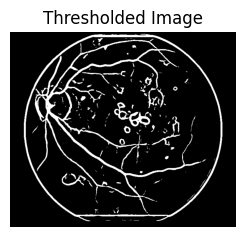

In [10]:
_, thresh = cv2.threshold(vessels, 0, 255, cv2.THRESH_BINARY)

plt.subplot(1, 2, 1)
plt.title("Thresholded Image")
plt.imshow(thresh, cmap='gray', vmin=0, vmax=255)
plt.axis('off')

### Hapus Small Elements
 mengambil citra biner dan nilai ambang batas ukuran sebagai input, menggunakan algoritma Connected Component Labeling dari OpenCV untuk melabeli objek-objek terhubung dalam citra, menghapus objek-objek yang ukurannya lebih kecil dari ambang batas ukuran serta mempertahankan objek-objek dengan lebar atau tinggi di atas 150 piksel, dan mengembalikan citra baru dengan elemen-elemen kecil yang telah dihapus. Pada baris terakhir, fungsi ini dipanggil dengan citra biner thresh dan ambang batas ukuran 800, dan hasilnya dikonversi ke tipe data np.uint8

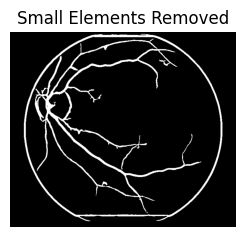

In [11]:
def remove_small_elements(image: np.ndarray, min_size: int) -> np.ndarray:
    components, output, stats, _ = cv2.connectedComponentsWithStats(
        image, connectivity=8)
    sizes = stats[1:, -1]
    width = stats[1:, -3]
    height = stats[1:, -2]
    components -= 1
    result = np.zeros((output.shape))
    for i in range(0, components):
        if sizes[i] >= min_size and (width[i] > 150 or height[i] > 150):
            result[output == i + 1] = 255
    return result

small_removed_frangi = remove_small_elements(thresh, 800).astype(np.uint8)

plt.subplot(1, 2, 1)
plt.title("Small Elements Removed")
plt.imshow(small_removed_frangi, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

### Remove Border
mengambil dua input: color_img yang merupakan citra berwarna dan image yang merupakan citra biner. Fungsi ini bertujuan untuk menghapus objek-objek di sekitar batas citra berwarna.

1. mengonversi citra berwarna dari format BGR ke RGB
2. mendefinisikan rentang nilai warna lower dan upper dalam ruang warna RGB untuk mendeteksi objek-objek yang ingin dipertahankan
3. membuat masker biner menggunakan cv2.inRange yang hanya memasukkan piksel-piksel yang berada dalam rentang warna yang didefinisikan,
4. menerapkan operasi bitwise AND antara citra biner image dan masker untuk mendapatkan hasil akhir yang hanya berisi objek-objek di dalam batas citra berwarna.

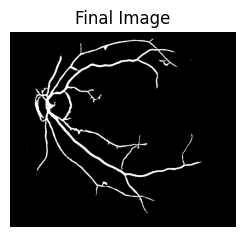

In [12]:
def remove_border(color_img: np.ndarray, image: np.ndarray) -> np.ndarray:
    RGB = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
    lower = np.array([0, 0, 80])
    upper = np.array([255, 255, 255])
    mask = cv2.inRange(RGB, lower, upper)
    
    return cv2.bitwise_and(image, mask)

end_result_frangi = remove_border(masked_image, small_removed_frangi)

plt.subplot(1, 2, 1)
plt.title("Final Image")
plt.imshow(end_result_frangi,cmap='gray',vmin=0, vmax=255)
plt.axis('off')
plt.show()

# Vessel Detecting Canny

### Manual Gray Image
mengubah gambar berwarna yang telah dimasker menjadi gambar grayscale. Pertama, gambar grayscale kosong dibuat. Setiap piksel dalam gambar berwarna diperiksa; jika sesuai dengan mask (nilai 255), komponen merah, hijau, dan birunya diambil untuk dihitung menjadi nilai grayscale menggunakan formula standar. Nilai grayscale kemudian dinormalisasi dan dikonversi ke tipe data uint8. Terakhir, gambar grayscale ditampilkan menggunakan dua plot: satu dengan skala warna default dan satu lagi dengan colormap grayscale.

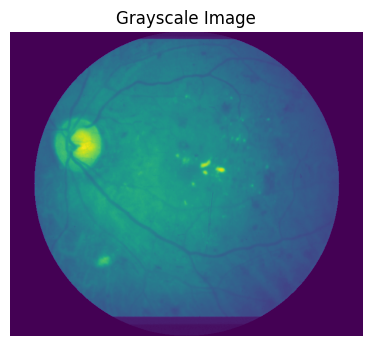

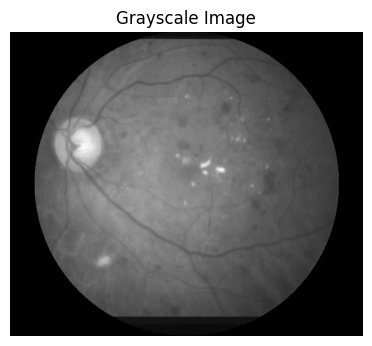

In [13]:

gray_image = np.zeros((h, w), dtype="float32")
for i in range(h):
    for j in range(w):
        if mask[i, j] == 255:
            R = masked_image[i, j, 0]
            G = masked_image[i, j, 1]
            B = masked_image[i, j, 2]
            gray_value = 0.2989 * R + 0.5870 * G + 0.1140 * B
            gray_image[i, j] = np.clip(gray_value, 0, 255) 

gray_image = (gray_image * 255 / gray_image.max()).astype("uint8")

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title("Grayscale Image")
plt.imshow(gray_image, vmin=0, vmax=255)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 2)
plt.title("Grayscale Image")
plt.imshow(gray_image,cmap='gray',vmin=0, vmax=255)
plt.axis('off')
plt.show()

### Adaptive Histogram Equalization (CLAHE)

menerapkan teknik peningkatan kontras pada gambar grayscale menggunakan CLAHE (Contrast Limited Adaptive Histogram Equalization). CLAHE adalah metode yang mengatur histogram secara lokal di setiap bagian gambar, sehingga meningkatkan kontras gambar tanpa memperkuat noise. Dalam kode ini, objek CLAHE dibuat dengan batas klip 2.0 dan ukuran grid 8x8. Kemudian, metode apply digunakan untuk menerapkan CLAHE pada gray_image, menghasilkan enhanced_gray_image yang memiliki kontras yang lebih baik dibandingkan dengan gambar asli.

(-0.5, 699.5, 604.5, -0.5)

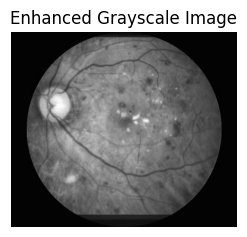

In [14]:

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_gray_image = clahe.apply(gray_image)

plt.subplot(1, 2, 1)
plt.title("Enhanced Grayscale Image")
plt.imshow(enhanced_gray_image, cmap='gray', vmin=0, vmax=255)
plt.axis('off')


### Search edge
 
menghaluskan gambar grayscale yang telah ditingkatkan kontrasnya (enhanced_gray_image) menggunakan Gaussian Blur dengan ukuran kernel 5x5 untuk mengurangi noise. Setelah itu, gambar yang dihasilkan (blurred_image) digunakan sebagai input untuk algoritma deteksi tepi Canny dengan ambang batas bawah 60 dan ambang batas atas 150. Hasilnya adalah gambar biner (vessel_image) yang menyoroti tepi-tepi yang ada di gambar, yang dalam konteks ini kemungkinan besar adalah pembuluh darah pada gambar retina.

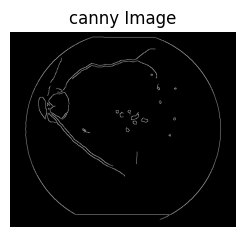

In [15]:
blurred_image = cv2.GaussianBlur(enhanced_gray_image, (5, 5), 0)
vessel_image = cv2.Canny(blurred_image, 60, 150)

plt.subplot(1, 2, 1)
plt.title("canny Image")
plt.imshow(vessel_image, cmap='gray')
plt.axis('off')
plt.show()

### Morphology

serangkaian operasi morfologi pada gambar biner (vessel_image) yang dihasilkan dari deteksi tepi Canny. Pertama, sebuah kernel berbentuk elips dengan ukuran 3x3 didefinisikan. Kemudian, operasi morfologi gradien diterapkan untuk menyoroti tepi-tepi objek dalam gambar (morph_image). Setelah itu, gambar tersebut dilatasi untuk memperluas tepi-tepi, diikuti dengan operasi penutupan untuk mengisi celah-celah kecil dalam objek (closing). Gambar hasil penutupan kemudian di-erosikan untuk mengurangi ukuran objek kembali. Akhirnya, gambar yang dihasilkan dihaluskan menggunakan Gaussian Blur dengan kernel 5x5 untuk mengurangi noise dan memperhalus tepi-tepi objek dalam gambar (smoothed_vessels_canny).

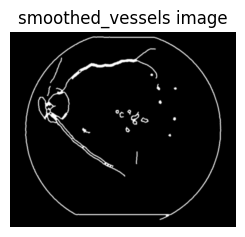

In [28]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
morph_image = cv2.morphologyEx(vessel_image, cv2.MORPH_GRADIENT, kernel)
dilated = cv2.dilate(morph_image, kernel, iterations=1)
closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel, iterations=1)
eroded = cv2.erode(closing, kernel, iterations=1)
smoothed_vessels_canny = cv2.GaussianBlur(eroded, (5, 5), 0)

plt.subplot(1, 2, 1)
plt.title("smoothed_vessels image")
plt.imshow(smoothed_vessels_canny, cmap='gray')
plt.axis('off')

plt.show()

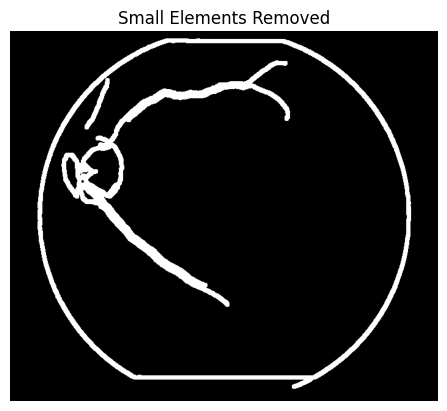

In [29]:

small_remove_canny = remove_small_elements(smoothed_vessels_canny,800).astype(np.uint8)

plt.subplot(1, 2, 1)
plt.title("Small Elements Removed")
plt.imshow(small_remove_canny, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

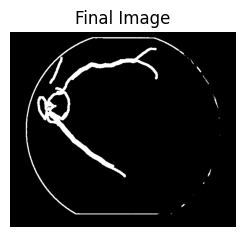

In [30]:
end_result_canny = remove_border(masked_image, small_remove_canny)

plt.subplot(1, 2, 1)
plt.title("Final Image")
plt.imshow(end_result_canny,cmap='gray',vmin=0, vmax=255)
plt.axis('off')
plt.show()


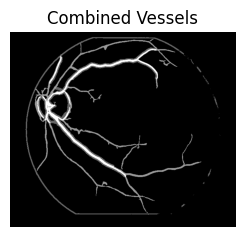

In [31]:
combined_vessels = cv2.addWeighted(end_result_frangi, 0.6, end_result_canny, 0.4, 0)

plt.subplot(1, 2, 1)
plt.title("Combined Vessels")
plt.imshow(combined_vessels, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

# Partition to create DB

In [32]:
def create_partition_dir(image_path):
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    partition_dir = os.path.join('partitions', image_name)
    if not os.path.exists(partition_dir):
        os.makedirs(partition_dir)
    return partition_dir

In [33]:
partition_height = 300  # tinggi setiap partisi
partition_width = 300   # lebar setiap partisi
step_size = 150         # ukuran langkah sliding window
partitions = []

for y in range(0, h - partition_height + 1, step_size):
    for x in range(0, w - partition_width + 1, step_size):
        partition = combined_vessels[y:y + partition_height, x:x + partition_width]
        partitions.append((partition, y, x))  # Save the partition along with its coordinates

partition_dir = create_partition_dir(image_path)

### SIFT (Scale-Invariant Feature Transform)

In [34]:
# Save partitions to disk and create descriptors
sift = cv2.SIFT_create()
db_path = 'retina_images.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Create the database table if it doesn't exist
cursor.execute('''
    CREATE TABLE IF NOT EXISTS images (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        path TEXT NOT NULL,
        y INTEGER NOT NULL,
        x INTEGER NOT NULL,
        keypoints BLOB NOT NULL,
        descriptors BLOB NOT NULL
    )
''')

for i, (partition, y, x) in enumerate(partitions):
    partition_path = os.path.join(partition_dir, f'partition_{i}.png')
    if not os.path.exists(partition_path):
        cv2.imwrite(partition_path, partition)

        keypoints, descriptors = sift.detectAndCompute(partition, None)
        keypoints_blob = sqlite3.Binary(pickle.dumps([kp.pt for kp in keypoints]))
        descriptors_blob = sqlite3.Binary(pickle.dumps(descriptors))

        cursor.execute('''
            INSERT INTO images (path, y, x, keypoints, descriptors)
            VALUES (?, ?, ?, ?, ?)
        ''', (partition_path, y, x, keypoints_blob, descriptors_blob))

conn.commit()
conn.close()

print("Partitions and descriptors   have been saved to the database.")

Partitions and descriptors   have been saved to the database.


In [35]:
#Create the database schema and populate it with partition data
def create_database(partition_dir):
    conn = sqlite3.connect('retina_partitions.db')
    cursor = conn.cursor()
    
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS images (
            id INTEGER PRIMARY KEY,
            path TEXT,
            keypoints BLOB,
            descriptors BLOB
        )
    ''')
    
    sift = cv2.SIFT_create()
    partitions = []

    for filename in os.listdir(partition_dir):
        partition_path = os.path.join(partition_dir, filename)
        partition = cv2.imread(partition_path, cv2.IMREAD_GRAYSCALE)
        partitions.append((partition, partition_path))

    for i, (partition, partition_path) in enumerate(partitions):
        keypoints, descriptors = sift.detectAndCompute(partition, None)
        keypoints_blob = sqlite3.Binary(pickle.dumps([kp.pt for kp in keypoints]))
        descriptors_blob = sqlite3.Binary(pickle.dumps(descriptors))

        cursor.execute('''
            INSERT INTO images (path, keypoints, descriptors)
            VALUES (?, ?, ?)
        ''', (partition_path, keypoints_blob, descriptors_blob))

    conn.commit()
    conn.close()